# Pre-trained Vectors - Sentence -  Toxic Comments

A corpus of manually labeled comments - classifying each comment by its type of toxicity is available on Kaggle. We will aim to do a binary classification of whether a comment is toxic or not

This notebook uses **Pre-trained Sentence Embedding** from Spacy to do the task.

In [23]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import vis

### Get the Data

Uncomment these shell lines to get the data

In [24]:
#!wget http://bit.do/deep_toxic_train -P data/
#!mv data/deep_toxic_train data/train.zip

In [25]:
df = pd.read_csv("data/train.zip")

In [26]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Create the Input & Output Data

In [6]:
train_sentences = df["comment_text"]
train_sentences.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [28]:
labels = df.iloc[:,2].values

In [29]:
from keras.utils import to_categorical
y = to_categorical(labels)

## Creating the sentence embedding for learning

In [30]:
import spacy
#!python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

In [31]:
doc = nlp("This is some text")
from spacy import displacy
displacy.render(doc, jupyter=True)

In [32]:
# Word Vector
doc[3].vector.shape

(300,)

In [33]:
# Sentence Vector
doc.vector.shape

(300,)

In [34]:
def get_vector(sentence):
    vector = nlp(sentence).vector
    return vector

In [35]:
from tqdm import tqdm, tqdm_pandas
tqdm.pandas(desc="progress")

In [36]:
X = train_sentences.progress_apply(get_vector)

progress: 100%|██████████| 159571/159571 [47:30<00:00, 55.99it/s]


In [39]:
Xvec = np.vstack(X)

In [40]:
Xvec.shape

(159571, 300)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Xvec, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127656, 300), (31915, 300), (127656, 2), (31915, 2))

### Step 2: Create the Model Architecture

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [47]:
model = Sequential()
model.add(Dense(128, input_dim = 300, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(2, activation="sigmoid"))

### Step 3: Compile the Model & Fit on the Data

In [48]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [49]:
output = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 4s 38us/step - loss: 0.1519 - acc: 0.9436 - val_loss: 0.1470 - val_acc: 0.9392
Epoch 2/5
102124/102124 [==============================] - 3s 29us/step - loss: 0.1249 - acc: 0.9531 - val_loss: 0.1228 - val_acc: 0.9541
Epoch 3/5
102124/102124 [==============================] - 3s 29us/step - loss: 0.1219 - acc: 0.9545 - val_loss: 0.1210 - val_acc: 0.9554
Epoch 4/5
102124/102124 [==============================] - 3s 29us/step - loss: 0.1181 - acc: 0.9561 - val_loss: 0.1193 - val_acc: 0.9547
Epoch 5/5
102124/102124 [==============================] - 3s 29us/step - loss: 0.1163 - acc: 0.9568 - val_loss: 0.1241 - val_acc: 0.9549


### Step 4: Evaluate the Model

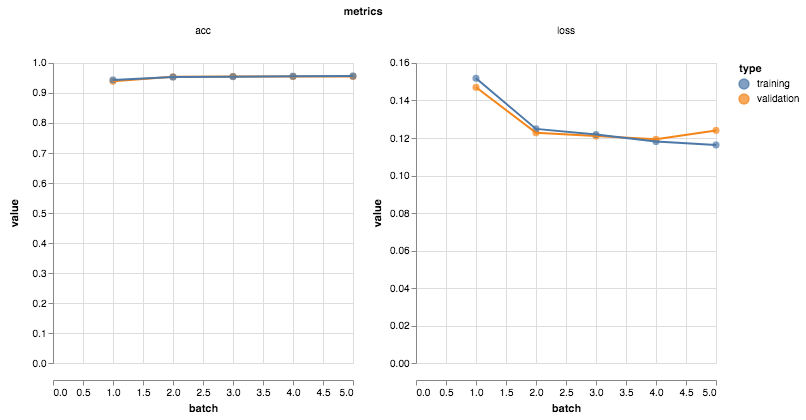

In [50]:
vis.metrics(output.history)

In [51]:
score = model.evaluate(X_test, y_test, verbose=1)

31915/31915 [==============================] - 1s 33us/step


In [52]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12506679729801462
Test accuracy: 0.9540811530628232


### Step 5: Visualise evaluation & Make a prediction

In [53]:
predict_classes = model.predict_classes(X_test)

In [54]:
actual_classes = np.dot(y_test,np.array([[0],[1]])).reshape(-1)

In [55]:
pd.crosstab(actual_classes, predict_classes)

col_0,0,1
row_0,,
0.0,28600,259
1.0,1209,1847
